# VISUAL CADENCE ANALYZER
## This builds an interface to the _cadence_expert_ system using PySWIP.

Main functionalities are:

1. **Chord Analysis** - Analyze Individual Chords
2. **Progression Analysis** - Analyze Chord Progressions
3. **Cadence Pattern Detection** - Identify Cadence Patterns
4. **Visualization** - Graphic Display of Analysis Results
5. **Interactive Input** - More User-friendly Input (compared to Prolog, at least)
6. **Knowledge Base Expansion** - Add New Chords to the System

## Some Literature I used

As expert systems are no longer the focal point of current AI research, most literature comes from the heydays of symbolic AI during the 1980s.

+ Patrick Blackburn, Johan Bos, and Kristina Striegnitz: "Learn Prolog Now!", London: King's College, 2006 (Texts in Computing 7) -- Prolog primer
+ "Einführung in die Künstliche Intelligenz", vol. 2, ed. by Manfred Strede, Strendlingen: Luther, 1984 -- theory and architecture of expert systems
+ Michael Roth, "Die intelligente Maschine: Der Computer als Experte", Leipzig, Jena, Berlin (Ost): Urania, 1988 -- at times slightly curious Socialist/utopian views of AI

Further ideas about expert systems can be found in books concerned with the second big AI coding language, LISP, eg.:

+ A. A. Berk, "LISP: The Language of Artificial Intelligence", New York: van Nostrand Reinhold, 1985
+ A. Bundy, "Praktische Einführung in die Künstliche Intelligenz", Munich: IWT, 1986

## Imports and Initiliazation

In [ ]:
import os, sys
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import clear_output, display, Markdown, HTML
from pyswip import Prolog

PROLOG_FILE = "cadence_expert.pl"

if not os.path.exists(PROLOG_FILE):
    print(f"ERROR: File '{PROLOG_FILE}' not found in folder '{os.getcwd()}'.'")
    sys.exit(1)

prolog = Prolog()
prolog.consult(PROLOG_FILE)

print(f"Prolog System '{PROLOG_FILE}' initialized.")

## Functions for Chord and Progression Analysis

In [14]:
def analyze_chord(bass, figure):
    """
    Analyze a single chord.

    bass is a character ("c", "g"),
    figure is a string ("5/3", "6")
    """

    results = list(prolog.query(f"analyze_chord({bass}, '{figure}', ChordName, Function)"))

    if results:
        return {
            "bass"      : bass,
            "figure"    : figure,
            "chord_name": results[0]["ChordName"],
            "function"  : results[0]["Function"]
        }

    else:
        return {
            "bass"      : bass,
            "figure"    : figure,
            "chord_name": "unknown",
            "function"  : "unknown"
        }

def analyze_progression(chord_list):
    """
    Analyze a chord progression.

    chord_list is a list of (bass, figure) tuples.
    """

    # Build the list of terms in Prolog format
    chord_terms = "[" + ",".join([f"chord({bass},'{figure}')" for bass, figure in chord_list]) + "]"

    results = list(prolog.query(
        f"clear_explanations, analyze_progression({chord_terms}, Analysis), detect_cadence(Analysis, CadenceType)"
    ))

    analyses = []
    cadence_type = "Could not find cadence type."

    if results:
        for result in results:
            if "CadenceType" in result:
                cadence_type = result["CadenceType"]
                break

    analyses = [analyze_chord(bass, figure) for bass, figure in chord_list]

    explanations = list(prolog.query("explanation(Text)"))
    explanation_texts = [exp["Text"] for exp in explanations]

    return analyses, cadence_type, explanation_texts

## Function for Interactive Analysis

In [15]:
def interactive_chord_analysis():
    """
    Interactively analyze chords
    """

    print("Chord Progression Analyzer")
    print("==========================")
    print("Please enter bass tones and figures, like ' c 5/3 '.")
    print("Blank input ends the progression and triggers the analysis.")
    print("Bass tones can be any of the following: c, d, e, f, g, a, b")
    print("Figures: 5/3 for root position, 6 for first inversion")

    progression = []

    while True:
        chord_input = input(f"Chord {len(progression) + 1} (press Enter to stop): ").strip()

        if not chord_input:
            break

        parts = chord_input.split()
        if len(parts) != 2:
            print("Wrong input! Use this format: <bass> <figure>")
            continue

        bass, figure = parts
        if bass not in ["c", "d", "e", "f", "g", "a", "b"]:
            print(f"Illegal bass tone: '{bass}'. Valid tones are: c, d, e, f, g, a, b.")
            continue

        if figure not in ["5/3", "6"]:
            print(f"Illegal figure: '{figure}'. Valid figures are: 5/3, 6.")
            continue

        progression.append((bass, figure))
        print(f"Added chord: {bass} {figure}")

    if not progression:
        print("No chords entered.")
        return

    clear_output()
    print(f"Analyzing the progression of {len(progression)} chords:")
    for i, (bass, figure) in enumerate(progression):
        print(f"{i + 1}. {bass} {figure}")

    analyses, cadence_type, explanations = analyze_progression(progression)
    visualize_analysis(analyses, cadence_type, explanations)


## Functions for Knowledge Base Management

In [16]:
def add_chord_definition(bass, figure, chord_name, function):
    """
    Add a new chord definition to the Prolog system.
    """

    list(prolog.query(
        f"add_chord_fact({bass}, '{figure}', '{chord_name}', {function})"
    ))

    print(f"Chord definition added: {bass} {figure} -> {chord_name} ({function})")


def list_available_chords():
    """
    Show all chords currently available in the Prolog system.
    """

    results = list(prolog.query(
        "chord_def(Bass, Figure, Name, Function)"
    ))

    html = "<h3>Available Chord Definitions</h3>"
    html += "<table style='width:80%; border-collapse:collapse; margin:10px 0;'>"
    html += "<tr><th style='border:1px solid #ddd; padding:8px; text-align:center; background-color:#f2f2f2;'>Bass</th>"
    html += "<th style='border:1px solid #ddd; padding:8px; text-align:center; background-color:#f2f2f2;'>Figure</th>"
    html += "<th style='border:1px solid #ddd; padding:8px; text-align:center; background-color:#f2f2f2;'>Chord Name</th>"
    html += "<th style='border:1px solid #ddd; padding:8px; text-align:center; background-color:#f2f2f2;'>Function</th></tr>"

    for result in results:
        html += "<tr>"
        html += f"<td style='border:1px solid #ddd; padding:8px; text-align:center;'>{result['Bass']}</td>"
        html += f"<td style='border:1px solid #ddd; padding:8px; text-align:center;'>{result['Figure']}</td>"
        html += f"<td style='border:1px solid #ddd; padding:8px; text-align:center;'>{result['Name']}</td>"
        html += f"<td style='border:1px solid #ddd; padding:8px; text-align:center;'>{result['Function']}</td>"
        html += "</tr>"
    html += "</table>"

    display(HTML(html))


list_available_chords()

Bass,Figure,Chord Name,Function
c,5/3,C major,tonic
d,5/3,D minor,supertonic
e,5/3,E minor,mediant
f,5/3,F major,subdominant
g,5/3,G major,dominant
a,5/3,A minor,submediant
b,5/3,B diminished,leadingtone


## Functions for Visualization

In [17]:
def get_contrasting_text_color(hex_color):
    hex_color = hex_color.lstrip("#")
    r, g, b = int(hex_color[0:2], 16), int(hex_color[2:4], 16), int(hex_color[4:6], 16)     # convert hex to RGB
    luminance = (0.299 * r + 0.587 * g + 0.114 * b)                                         # calculate luminance

    return "#000000" if luminance > 186 else "#ffffff"


def visualize_analysis(analyses, cadence_type, explanations=None):
    """
    Visualize analysis
    """

    color_map = {
        "tonic"      : "#8dd3c7",       "dominant"   : "#fb8072",
        "subdominant": "#80b1d3",       "supertonic" : "#fdb462",
        "mediant"    : "#b3de69",       "submediant" : "#fccde5",
        "leadingtone": "#d9d9d9",       "unknown"    : "#ffffff"
    }

    # Construct HTML table for the analysis results
    html = "<h3>Chord Analysis</h3>"
    html += "<table style='width:80%; border-collapse:collapse; margin:10px 0;'>"
    html += "<tr>"
    for column in ["Bass", "Figures", "Chord Name", "Function"]:
        html += f"<th style='border:1px solid #ddd; padding:8px; background-color:#f2f2f2; text-align:center;'>{column}</th>"
    html += "</tr>"

    for analysis in analyses:
        bg_color = color_map.get(analysis["function"], "#ffffff")
        text_color = get_contrasting_text_color(bg_color)

        html += f"<tr style='background-color:{bg_color};'>"
        html += f"<td style='border:1px solid #ddd; padding:8px; text-align:center; color:{text_color};'>{analysis['bass']}</td>"
        html += f"<td style='border:1px solid #ddd; padding:8px; text-align:center; color:{text_color};'>{analysis['figure']}</td>"
        html += f"<td style='border:1px solid #ddd; padding:8px; text-align:center; color:{text_color};'>{analysis['chord_name']}</td>"
        html += f"<td style='border:1px solid #ddd; padding:8px; text-align:center; color:{text_color};'>{analysis['function']}</td>"
        html += "</tr>"
    html += "</table>"

    html += f"<h3>Cadence Analysis</h3><p>{cadence_type}</p>"

    fig, ax = plt.subplots(figsize=(10, 3))

    x = np.arange(len(analyses))
    colors = [color_map.get(analysis["function"], "#ffffff") for analysis in analyses]

    bars = ax.bar(x, [1] * len(analyses), color=colors, width=0.7)
    ax.set_xticks(x)
    ax.set_xticklabels([f"{analysis['bass']} ({analysis['figure']})" for analysis in analyses])
    ax.set_title("Chord Progression")
    ax.set_yticks([])   # do not display Y axis

    # Print functions on graph
    for index, bar in enumerate(bars):
        ax.text(index, 0.5, analyses[index]["function"],
                ha="center", va="center",
                rotation=90 if len(analyses[index]["function"]) > 6 else 0)

    plt.tight_layout()
    plt.show()

    display(HTML(html))

    # Show explanations (if there are any)
    if explanations:
        display(Markdown("### Explanations of Inferred Knowledge:"))
        for exp in explanations:
            display(Markdown(f"- {exp}"))

# Test cases

## Test Case I: Analyze a Simple Authentic Cadence

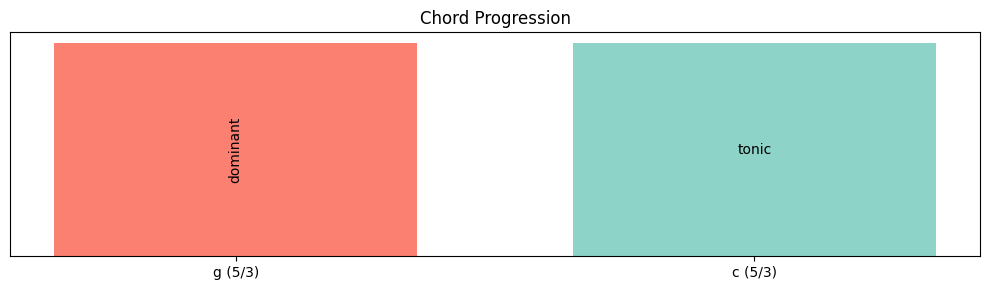

Bass,Figures,Chord Name,Function
g,5/3,G major,dominant
c,5/3,C major,tonic


### Explanations of Inferred Knowledge:

- Directly found chord: bass g with figure 5/3 is G major (dominant)

- Directly found chord: bass c with figure 5/3 is C major (tonic)

- b'Detected Authentic Cadence (dominant to tonic progression)'

- Directly found chord: bass g with figure 5/3 is G major (dominant)

- Directly found chord: bass c with figure 5/3 is C major (tonic)

In [18]:
progression = [
    ("g", "5/3"),
    ("c", "5/3")
]

analyses, cadence_type, explanations = analyze_progression(progression)
visualize_analysis(analyses, cadence_type, explanations)

## Test Case II: Analyze a I IV I V I Progression

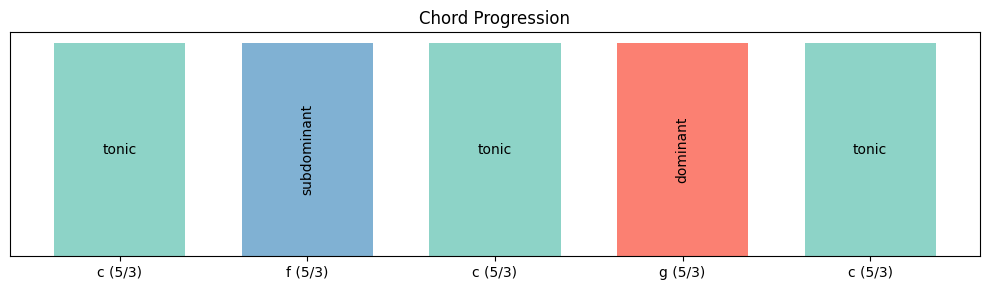

Bass,Figures,Chord Name,Function
c,5/3,C major,tonic
f,5/3,F major,subdominant
c,5/3,C major,tonic
g,5/3,G major,dominant
c,5/3,C major,tonic


### Explanations of Inferred Knowledge:

- Directly found chord: bass c with figure 5/3 is C major (tonic)

- Directly found chord: bass f with figure 5/3 is F major (subdominant)

- Directly found chord: bass c with figure 5/3 is C major (tonic)

- Directly found chord: bass g with figure 5/3 is G major (dominant)

- Directly found chord: bass c with figure 5/3 is C major (tonic)

- b'Detected Authentic Cadence (dominant to tonic progression)'

- b'Detected Plagal Cadence (subdominant to tonic progression).'

- Directly found chord: bass c with figure 5/3 is C major (tonic)

- Directly found chord: bass f with figure 5/3 is F major (subdominant)

- Directly found chord: bass c with figure 5/3 is C major (tonic)

- Directly found chord: bass g with figure 5/3 is G major (dominant)

- Directly found chord: bass c with figure 5/3 is C major (tonic)

In [19]:
progression = [
    ("c", "5/3"),
    ("f", "5/3"),
    ("c", "5/3"),
    ("g", "5/3"),
    ("c", "5/3")
]

analyses, cadence_type, explanations = analyze_progression(progression)
visualize_analysis(analyses, cadence_type, explanations)

## Test Case III: Analyze a Progression with a First Inversion Chord

Testing the progression [('b','6'),  ('c','5/3')]:

Detailed explanation (this is hard-coded in Python, not inferred by Prolog):
1. 'b/6' is a G major triad in first inversion: G B D -> B D G.
   While the lowest note is B, the chord's fundament is on G, one third below.
2. If all works well, the system will detect this and, by constructing the G major,
   infer that this in fact an authentic cadence V I with a root progression G C.



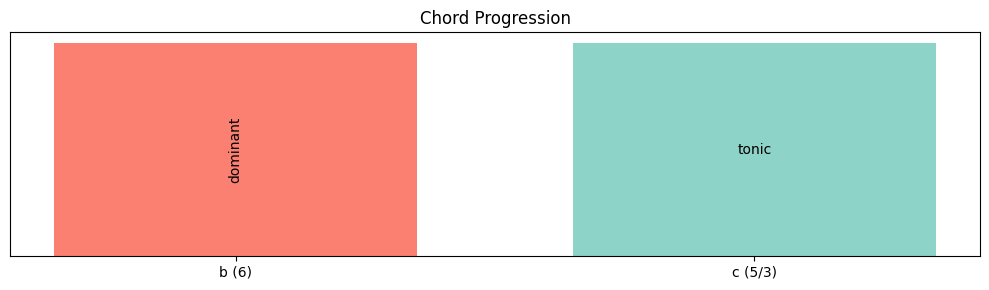

Bass,Figures,Chord Name,Function
b,6,G major,dominant
c,5/3,C major,tonic


### Explanations of Inferred Knowledge:

- Deep inference: For bass b with figure '6', inferred root g leading to G major (dominant)

- Directly found chord: bass c with figure 5/3 is C major (tonic)

- b'Detected Authentic Cadence (dominant to tonic progression)'

- Deep inference: For bass b with figure '6', inferred root g leading to G major (dominant)

- Directly found chord: bass c with figure 5/3 is C major (tonic)

In [20]:
print("Testing the progression [('b','6'),  ('c','5/3')]:")
print("\nDetailed explanation (this is hard-coded in Python, not inferred by Prolog):")
print("1. 'b/6' is a G major triad in first inversion: G B D -> B D G.")
print("   While the lowest note is B, the chord's fundament is on G, one third below.")
print("2. If all works well, the system will detect this and, by constructing the G major,")
print("   infer that this in fact an authentic cadence V I with a root progression G C.\n")

progression = [
    ("b", "6"),
    ("c", "5/3")
]

analyses, cadence_type, explanations = analyze_progression(progression)
visualize_analysis(analyses, cadence_type, explanations)